In [2]:
# Step 1: Imports
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2

In [3]:
# Paths
MODEL_PATH = "MapSegmentationGenerator.keras"
IMAGE_PATH = "Assen.png"

In [5]:
# Step 2: Load model with correct compilation
model = load_model(MODEL_PATH, compile=True)  # Use compile=True to keep original settings

In [6]:
# Step 3: Function to tile an image
def tile_image(image, tile_size=(128, 128)):
    """
    Splits an image into tiles of given size.
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    width, height = image.size
    tiles = []
    tile_coordinates = []  # Store coordinates for stitching

    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            # Crop tile
            tile = image.crop((x, y, x + tile_size[0], y + tile_size[1]))

            # If tile is smaller, pad it
            if tile.size != tile_size:
                new_tile = Image.new("RGB", tile_size, (0, 0, 0))
                new_tile.paste(tile, (0, 0))
                tile = new_tile

            tiles.append(np.array(tile))
            tile_coordinates.append((x, y))
    
    return tiles, tile_coordinates

In [7]:
# Step 4: Load and preprocess the image
original_image = Image.open(IMAGE_PATH).convert("RGB")
tiles, tile_coordinates = tile_image(original_image, (128, 128))

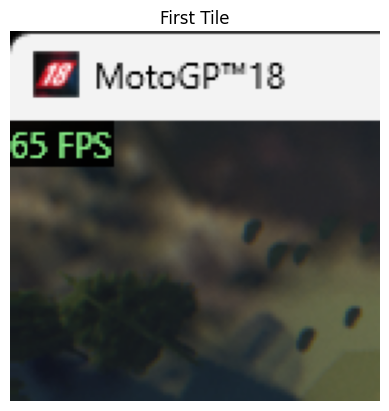

In [8]:
# Show the first tile
plt.imshow(tiles[0])
plt.title("First Tile")
plt.axis("off")
plt.show()

In [9]:
# Step 5: Predict on all tiles with proper preprocessing
def preprocess_tile(tile):
    """Preprocess tile to match training data format"""
    # Convert to float and normalize to [0, 1]
    tile = tile.astype(np.float32) / 255.0
    return tile

predictions = []
for tile in tiles:
    processed_tile = preprocess_tile(tile)
    prediction = model.predict(np.expand_dims(processed_tile, axis=0))
    predictions.append(prediction[0])  # Remove batch dimension

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━

In [10]:
# Step 6: Visualization function
def visualize_results(predicted_mask, original_image):
    predicted_mask = np.squeeze(predicted_mask)
    plt.figure(figsize=(8, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Tile')
    plt.axis('off')

    # Prediction
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray', vmin=0, vmax=1)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

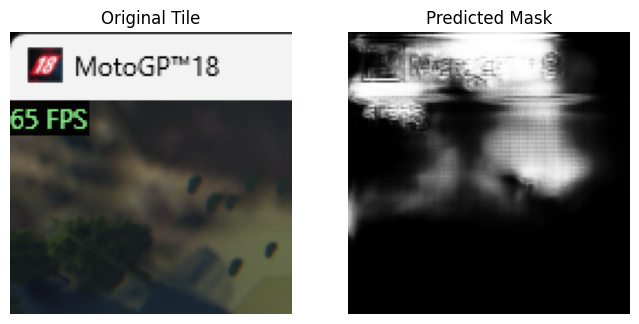

In [11]:
# Step 7: Show results for first tile
visualize_results(predictions[0], tiles[0])

In [12]:
# Step 8: Improved stitch function
def stitch_tiles(tile_predictions, original_size, tile_coordinates, tile_size=(128, 128)):
    """
    Stitches a list of tile predictions back into the original image size.
    """
    width, height = original_size
    stitched = np.zeros((height, width), dtype=np.float32)

    for (x, y), prediction in zip(tile_coordinates, tile_predictions):
        # Extract the mask from prediction
        if prediction.ndim == 3:  # (H, W, 1)
            mask = prediction[:, :, 0]
        else:  # (H, W)
            mask = prediction
        
        # Determine actual tile dimensions (for edge tiles)
        h = min(tile_size[1], height - y)
        w = min(tile_size[0], width - x)
        
        # Place the tile in the stitched image
        stitched[y:y+h, x:x+w] = mask[:h, :w]

    return stitched


# Step 9: Stitch predictions back into full mask
original_size = original_image.size  # (width, height)
stitched_mask = stitch_tiles(predictions, original_size, tile_coordinates, (128, 128))

In [13]:
def stitch_tiles(tiles, image_size, tile_size=(128, 128)):
    """
    Stitches a list of tiles back into the original image size.

    Args:
        tiles (list of np.ndarray): List of tiles (predictions or images).
        image_size (tuple): (width, height) of the original image.
        tile_size (tuple): Size of each tile (width, height).

    Returns:
        np.ndarray: Stitched image.
    """
    width, height = image_size
    stitched = np.zeros((height, width), dtype=np.float32)  # for mask, 1 channel

    tile_idx = 0
    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            tile = tiles[tile_idx]

            # Ensure tile is 2D (mask only)
            if tile.ndim == 4:  # (1, H, W, 1)
                tile = tile[0, :, :, 0]
            elif tile.ndim == 3 and tile.shape[-1] == 1:  # (H, W, 1)
                tile = tile[:, :, 0]

            h = min(tile_size[1], height - y)
            w = min(tile_size[0], width - x)

            stitched[y:y+h, x:x+w] = tile[:h, :w]
            tile_idx += 1

    return stitched


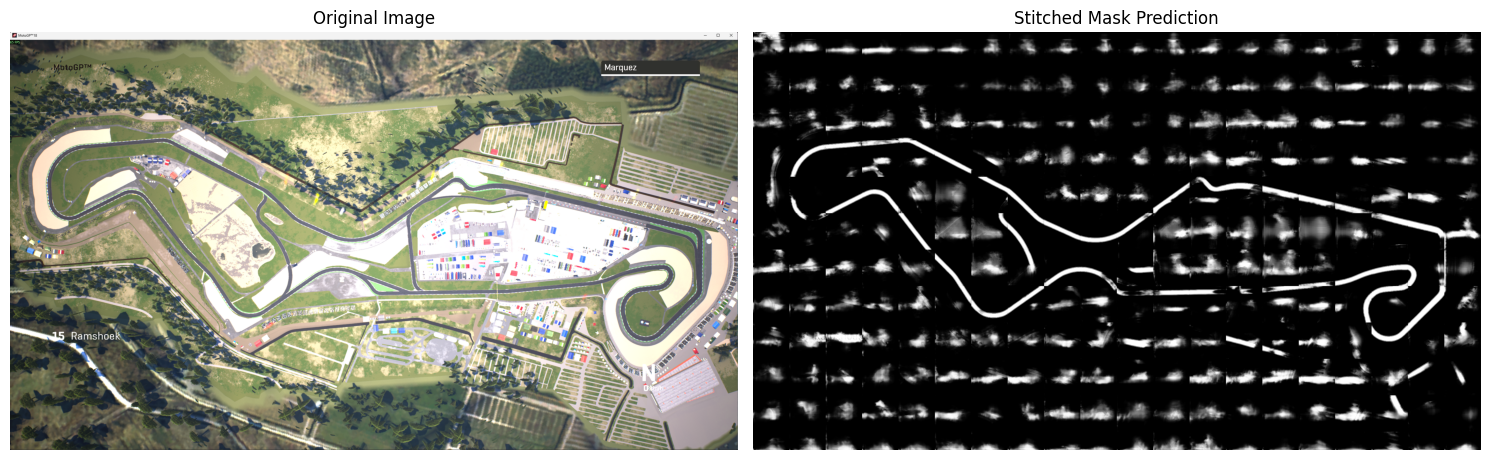

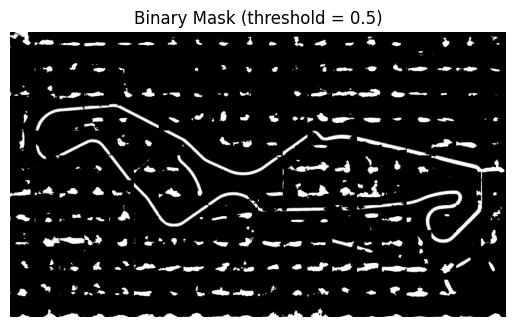

In [14]:
# Step 10: Show stitched result
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(stitched_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Stitched Mask Prediction')
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Save the result
stitched_mask_image = (stitched_mask * 255).astype(np.uint8)
Image.fromarray(stitched_mask_image).save('predicted_mask.png')

# Optional: Apply threshold for binary mask
binary_mask = (stitched_mask > 0.5).astype(np.uint8)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask (threshold = 0.5)')
plt.axis('off')
plt.show()

In [15]:
def tile_image_large(image, crop_size=(246, 246), model_input_size=(128, 128)):
    """
    Splits an image into larger tiles and resizes them for the model.

    Args:
        image (PIL.Image or np.ndarray): Input image.
        crop_size (tuple): (width, height) of the crop from original image.
        model_input_size (tuple): Size to resize for the model.

    Returns:
        list: List of resized tiles (for model).
        list: List of original-sized tiles (for later upscaling mask).
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    width, height = image.size
    resized_tiles = []
    original_tiles = []

    for y in range(0, height, crop_size[1]):
        for x in range(0, width, crop_size[0]):
            # Crop larger tile
            tile = image.crop((x, y, x + crop_size[0], y + crop_size[1]))

            # Pad if smaller
            if tile.size != crop_size:
                new_tile = Image.new("RGB", crop_size, (0, 0, 0))
                new_tile.paste(tile, (0, 0))
                tile = new_tile

            original_tiles.append(np.array(tile))  # Save original crop size
            resized_tile = tile.resize(model_input_size, Image.BILINEAR)
            resized_tiles.append(np.array(resized_tile))

    return resized_tiles, original_tiles


In [16]:
# Load and create tiles
resized_tiles, original_tiles = tile_image_large(original_image, crop_size=(246, 246), model_input_size=(128, 128))

predictions = []
for tile in resized_tiles:
    tile_input = np.expand_dims(tile, axis=0)
    pred = model.predict(tile_input, verbose=0)
    # Upscale back to crop size for stitching
    pred_upscaled = Image.fromarray(np.squeeze(pred) * 255).resize((246, 246), Image.BILINEAR)
    pred_upscaled = np.array(pred_upscaled) / 255.0
    predictions.append(pred_upscaled)


In [17]:
def stitch_tiles_large(tiles, image_size, crop_size=(246, 246)):
    width, height = image_size
    stitched = np.zeros((height, width), dtype=np.float32)

    tile_idx = 0
    for y in range(0, height, crop_size[1]):
        for x in range(0, width, crop_size[0]):
            h = min(crop_size[1], height - y)
            w = min(crop_size[0], width - x)
            stitched[y:y+h, x:x+w] = tiles[tile_idx][:h, :w]
            tile_idx += 1

    return stitched

stitched_mask = stitch_tiles_large(predictions, original_image.size, crop_size=(246, 246))


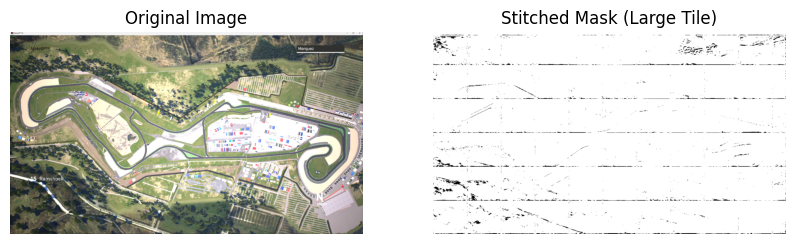

In [18]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(stitched_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Stitched Mask (Large Tile)')
plt.axis('off')
plt.show()
